In [3]:
#---------------------------------------------------
#导入库
#----------------数据探索----------------
import pandas as pd
import numpy as np
from tqdm import tqdm
#----------------核心模型----------------
import lightgbm as lgb
#----------------忽略报警----------------
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('/kaggle/input/gaidc-fadongji/train.csv')
test_df = pd.read_csv('/kaggle/input/gaidc-fadongji/preliminary_A.csv')

In [4]:
from catboost import CatBoostClassifier

from catboost import CatBoostRegressor
import xgboost as xgb


In [5]:
import optuna

In [6]:
train_df

,id,transformers,date_id,month,is_weekend,time,L1,L2,L3,L4,L5,L6,y
0,M1_D00003_00_00,M1,D00003,4,0,0:00,16.4772,11.6558,4.4320,6.4635,4.3713,1.1885,9.7434
1,M1_D00003_00_30,M1,D00003,4,0,0:30,16.2091,11.8867,4.4020,6.4640,4.6197,1.1879,9.9550
2,M1_D00003_01_00,M1,D00003,4,0,1:00,15.9085,11.5495,4.3407,6.5308,4.0870,1.1272,10.1302
3,M1_D00003_01_30,M1,D00003,4,0,1:30,15.7744,11.3179,4.2491,6.0959,4.1756,1.0818,10.5524
4,M1_D00003_02_00,M1,D00003,4,0,2:00,15.6739,11.4603,4.3714,6.6315,4.2463,1.1573,10.3770
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,M2_D00720_21_30,M2,D00720,1,0,21:30,43.9366,46.8299,-2.7134,0.0004,0.0002,0.0005,2.6271
38396,M2_D00720_22_00,M2,D00720,1,0,22:00,39.6642,42.7015,-2.6810,0.0004,-1.6484,0.0004,2.6273
38397,M2_D00720_22_30,M2,D00720,1,0,22:30,39.0777,42.2995,-2.8787,0.0004,-0.7773,0.0001,2.8468
38398,M2_D00720_23_00,M2,D00720,1,0,23:00,37.6118,41.4551,-2.8789,0.0004,0.0000,0.0001,3.0666


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(0)
import seaborn as sns
sns.set()

In [8]:
def time_span(t):
    if t >= 0 and t < 5:
        return 0
    elif t >= 5 and t < 8:
        return 1
    elif t >= 8 and t < 11:
        return 2
    elif t >= 11 and t < 13:
        return 3
    elif t >= 13 and t < 16:
        return 4
    elif t >= 16 and t < 19:
        return 5
    elif t >= 19 and t < 24:
        return 6

train_df['hour'] = train_df['time'].apply(lambda x:int(x.split(':')[0]))
train_df['time_span'] = train_df['hour'].apply(time_span)

test_df['hour'] = test_df['time'].apply(lambda x:int(x.split(':')[0]))
test_df['time_span'] = test_df['hour'].apply(time_span)

In [9]:
train_df

,id,transformers,date_id,month,is_weekend,time,L1,L2,L3,L4,L5,L6,y,hour,time_span
0,M1_D00003_00_00,M1,D00003,4,0,0:00,16.4772,11.6558,4.4320,6.4635,4.3713,1.1885,9.7434,0,0
1,M1_D00003_00_30,M1,D00003,4,0,0:30,16.2091,11.8867,4.4020,6.4640,4.6197,1.1879,9.9550,0,0
2,M1_D00003_01_00,M1,D00003,4,0,1:00,15.9085,11.5495,4.3407,6.5308,4.0870,1.1272,10.1302,1,0
3,M1_D00003_01_30,M1,D00003,4,0,1:30,15.7744,11.3179,4.2491,6.0959,4.1756,1.0818,10.5524,1,0
4,M1_D00003_02_00,M1,D00003,4,0,2:00,15.6739,11.4603,4.3714,6.6315,4.2463,1.1573,10.3770,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,M2_D00720_21_30,M2,D00720,1,0,21:30,43.9366,46.8299,-2.7134,0.0004,0.0002,0.0005,2.6271,21,6
38396,M2_D00720_22_00,M2,D00720,1,0,22:00,39.6642,42.7015,-2.6810,0.0004,-1.6484,0.0004,2.6273,22,6
38397,M2_D00720_22_30,M2,D00720,1,0,22:30,39.0777,42.2995,-2.8787,0.0004,-0.7773,0.0001,2.8468,22,6
38398,M2_D00720_23_00,M2,D00720,1,0,23:00,37.6118,41.4551,-2.8789,0.0004,0.0000,0.0001,3.0666,23,6


In [10]:
from sklearn.model_selection import KFold

In [11]:
# 构建不同时间与变压器油温的关系
for f in [
    ['month'],['time'],['hour'],['time_span'],
    ['transformers','month'],['transformers','time'],['transformers','hour'],['transformers','time_span'],
    ['transformers','is_weekend','month'],['transformers','is_weekend','time'],['transformers','is_weekend','hour'],['transformers','is_weekend','time_span']
]:
    print('------------------ {} ------------------'.format('_'.join(f)))
    folds = KFold(n_splits=5, shuffle=True, random_state=2023)

    train_df['fold'] = None
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(train_df,train_df)):
        train_df.loc[val_idx, 'fold'] = fold_

    for i in ['y','L3','L5','L6']:
        colname = '_'.join(f) + f'_{i}_mean'

        if len(f) == 1:
            feat = f[0]
        elif len(f) == 2:
            train_df['_'.join(f)] = train_df[f[0]].astype(str) + '_' + train_df[f[1]].astype(str)
            test_df['_'.join(f)]  = test_df[f[0]].astype(str)  + '_' + test_df[f[1]].astype(str)
            feat = '_'.join(f)
        elif len(f) == 3:
            train_df['_'.join(f)] = train_df[f[0]].astype(str) + '_' + train_df[f[1]].astype(str) + '_' + train_df[f[2]].astype(str)
            test_df['_'.join(f)]  = test_df[f[0]].astype(str)  + '_' + test_df[f[1]].astype(str)  + '_' + test_df[f[2]].astype(str)
            feat = '_'.join(f)

        # train
        train_df[colname] = None
        for fold_,(trn_idx,val_idx) in enumerate(folds.split(train_df,train_df)):
            Log_trn = train_df.iloc[trn_idx]

            order_label = Log_trn.groupby([feat])[i].mean()
            tmp_df      = train_df.loc[train_df.fold==fold_, [feat]]
            train_df.loc[train_df.fold==fold_, colname] = tmp_df[feat].map(order_label)

        # test
        test_df[colname] = None
        order_label = train_df.groupby([feat])[i].mean()
        test_df[colname] = test_df[feat].map(order_label)

        if len(f) != 1:
            del train_df['_'.join(f)], test_df['_'.join(f)]

------------------ month ------------------
------------------ time ------------------
------------------ hour ------------------
------------------ time_span ------------------
------------------ transformers_month ------------------
------------------ transformers_time ------------------
------------------ transformers_hour ------------------
------------------ transformers_time_span ------------------
------------------ transformers_is_weekend_month ------------------
------------------ transformers_is_weekend_time ------------------
------------------ transformers_is_weekend_hour ------------------
------------------ transformers_is_weekend_time_span ------------------


In [12]:
train_df['L3*L6']=train_df['L3']*train_df["L6"]
test_df['L3*L6']=test_df['L3']*test_df["L6"]
train_df['L5*L6']=train_df['L5']*train_df["L6"]
test_df['L5*L6']=test_df['L5']*test_df["L6"]
train_df['L3*L5']=train_df['L3']*train_df["L5"]
test_df['L3*L5']=test_df['L3']*test_df["L5"]

In [11]:
#train_df[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
# raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)

In [ ]:
# for f in [
#     ['month'],['time'],['hour'],['time_span'],
#     ['transformers','month'],['transformers','time'],['transformers','hour'],['transformers','time_span'],
#     ['transformers','is_weekend','month'],['transformers','is_weekend','time'],['transformers','is_weekend','hour'],['transformers','is_weekend','time_span']
# ]:
#     del train_df['_'.join(f) + '_L1_mean']
#     del train_df['_'.join(f) + '_L2_mean']
#     del train_df['_'.join(f) + '_L4_mean']

In [103]:
train_df.columns

Index(['id', 'transformers', 'date_id', 'month', 'is_weekend', 'time', 'L1',
       'L2', 'L3', 'L4', 'L5', 'L6', 'y', 'fold', 'month_y_mean',
       'month_L3_mean', 'month_L5_mean', 'month_L6_mean', 'time_y_mean',
       'time_L3_mean', 'time_L5_mean', 'time_L6_mean', 'hour_y_mean', 'hour',
       'time_span', 'hour_L3_mean', 'hour_L5_mean', 'hour_L6_mean',
       'time_span_y_mean', 'time_span_L3_mean', 'time_span_L5_mean',
       'time_span_L6_mean', 'transformers_month_y_mean',
       'transformers_month_L3_mean', 'transformers_month_L5_mean',
       'transformers_month_L6_mean', 'transformers_time_y_mean',
       'transformers_time_L3_mean', 'transformers_time_L5_mean',
       'transformers_time_L6_mean', 'transformers_hour_y_mean',
       'transformers_hour_L3_mean', 'transformers_hour_L5_mean',
       'transformers_hour_L6_mean', 'transformers_time_span_y_mean',
       'transformers_time_span_L3_mean', 'transformers_time_span_L5_mean',
       'transformers_time_span_L6_mean',
 

In [13]:
train_df.to_csv('train_df_123456.csv',index=False)

<AxesSubplot:>

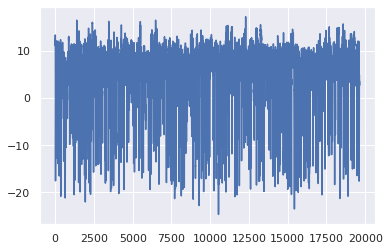

In [13]:
train_df.loc[train_df['transformers']=='M1','L2'].plot()

In [14]:
td=train_df.groupby('transformers',as_index=False)['L1'].rolling(window=3, min_periods=0).mean()#滑窗

In [15]:
train_df.groupby('transformers')['L1','L2','y'].agg(['mean','std'])

L1                    L2                     y           
                   mean        std       mean        std       mean        std
transformers                                                                  
M1             7.349877   7.081236   4.270436   6.861071  13.289860   8.499420
M2            36.852028  10.017057  43.469927  12.767040  26.620563  11.627922

In [16]:
train_df[['L1','L2','L3','L4','L5','L6','y']].corr()

,L1,L2,L3,L4,L5,L6,y
L1,1.000000,0.872169,-0.295995,0.713390,0.772313,-0.207336,0.489106
L2,0.872169,1.000000,-0.542743,0.551304,0.721953,-0.538564,0.540958
L3,-0.295995,-0.542743,1.000000,0.033562,-0.261907,0.331533,-0.393832
L4,0.713390,0.551304,0.033562,1.000000,0.928394,-0.022872,0.511931
L5,0.772313,0.721953,-0.261907,0.928394,1.000000,-0.226287,0.634139
L6,-0.207336,-0.538564,0.331533,-0.022872,-0.226287,1.000000,-0.243569
y,0.489106,0.540958,-0.393832,0.511931,0.634139,-0.243569,1.000000


<AxesSubplot:>

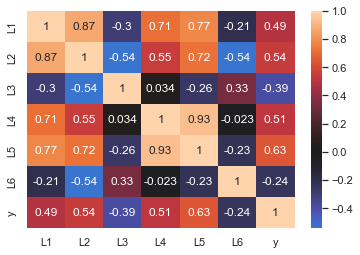

In [21]:
sns.heatmap(train_df[['L1','L2','L3','L4','L5','L6','y']].corr(),center=0,annot=True)

In [104]:
train_df['transformers'] = train_df['transformers'].map({'M1':1,'M2':2})
test_df['transformers']  = test_df['transformers'].map({'M1':1,'M2':2})
# 转换为了0-47的整数
train_df['time'] = train_df['time'].apply(lambda x:int(x.split(':')[0])*2 + int(x.split(':')[1])//30)
test_df['time']  = test_df['time'].apply(lambda x:int(x.split(':')[0])*2 + int(x.split(':')[1])//30)


In [105]:
train_df['transformers'] = train_df['transformers'].map({'M1':1,'M2':2})
test_df['transformers']  = test_df['transformers'].map({'M1':1,'M2':2})

In [106]:
cols = [f for f in train_df.columns if f not in ['id','date_id','y','fold']]

In [46]:
for f in [
    ['month'],['time'],['hour'],['time_span'],
    ['transformers','month'],['transformers','time'],['transformers','hour'],['transformers','time_span'],
    ['transformers','is_weekend','month'],['transformers','is_weekend','time'],['transformers','is_weekend','hour'],['transformers','is_weekend','time_span']
]:
    cols.remove('_'.join(f) + '_L2_mean')
    cols.remove('_'.join(f) + '_L4_mean')
    cols.remove('_'.join(f) + '_L1_mean')

In [113]:
cols

['transformers',
 'month',
 'is_weekend',
 'time',
 'L1',
 'L2',
 'L3',
 'L4',
 'L5',
 'L6',
 'month_y_mean',
 'month_L3_mean',
 'month_L5_mean',
 'month_L6_mean',
 'time_y_mean',
 'time_L3_mean',
 'time_L5_mean',
 'time_L6_mean',
 'hour_y_mean',
 'hour',
 'time_span',
 'hour_L3_mean',
 'hour_L5_mean',
 'hour_L6_mean',
 'time_span_y_mean',
 'time_span_L3_mean',
 'time_span_L5_mean',
 'time_span_L6_mean',
 'transformers_month_y_mean',
 'transformers_month_L3_mean',
 'transformers_month_L5_mean',
 'transformers_month_L6_mean',
 'transformers_time_y_mean',
 'transformers_time_L3_mean',
 'transformers_time_L5_mean',
 'transformers_time_L6_mean',
 'transformers_hour_y_mean',
 'transformers_hour_L3_mean',
 'transformers_hour_L5_mean',
 'transformers_hour_L6_mean',
 'transformers_time_span_y_mean',
 'transformers_time_span_L3_mean',
 'transformers_time_span_L5_mean',
 'transformers_time_span_L6_mean',
 'transformers_is_weekend_month_y_mean',
 'transformers_is_weekend_month_L3_mean',
 'transfo

## optuna调参

In [107]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [108]:
def objective_lgb(trial,data=train_df[cols].astype(float),target=train_df['y']):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'mae', 
        'random_state': 2023,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,30,40,50,60,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    mae = mean_absolute_error(test_y, preds)
    
    return mae

In [19]:
studylgb = optuna.create_study(direction='minimize')
studylgb.optimize(objective_lgb, n_trials=50)
print('Number of finished trials:', len(studylgb.trials))
print('Best trial:', studylgb.best_trial.params)

[I 2023-02-12 11:26:40,645] A new study created in memory with name: no-name-e7da33a3-d75b-47b4-8e43-f8627e70676d
[I 2023-02-12 11:28:21,808] Trial 0 finished with value: 2.1444366000958297 and parameters: {'reg_alpha': 0.25138543339678826, 'reg_lambda': 0.0021360309878561672, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 40, 'num_leaves': 298, 'min_child_samples': 125, 'min_data_per_groups': 1}. Best is trial 0 with value: 2.1444366000958297.
[I 2023-02-12 11:31:34,127] Trial 1 finished with value: 1.9879529611513365 and parameters: {'reg_alpha': 9.485675461417094, 'reg_lambda': 0.006663607444542141, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 1821, 'min_child_samples': 42, 'min_data_per_groups': 33}. Best is trial 1 with value: 1.9879529611513365.
[I 2023-02-12 11:32:13,855] Trial 2 finished with value: 2.0614791420123435 and parameters: {'reg_alpha': 0.006508475738679159, 'reg_lambda': 8.7373026

Number of finished trials: 50
Best trial: {'reg_alpha': 1.6226410710249066, 'reg_lambda': 0.01032660009474142, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 845, 'min_child_samples': 4, 'min_data_per_groups': 36}


In [109]:
studylgb356 = optuna.create_study(direction='minimize')
studylgb356.optimize(objective_lgb, n_trials=50)
print('Number of finished trials:', len(studylgb356.trials))
print('Best trial:', studylgb356.best_trial.params)

[I 2023-02-12 17:06:31,485] A new study created in memory with name: no-name-1fcc098f-eab5-4e3c-bc30-7f2de53c11c3
[I 2023-02-12 17:10:19,094] Trial 0 finished with value: 2.025533716941623 and parameters: {'reg_alpha': 0.08344698580716907, 'reg_lambda': 0.013869694580990645, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 40, 'num_leaves': 1654, 'min_child_samples': 80, 'min_data_per_groups': 95}. Best is trial 0 with value: 2.025533716941623.
[I 2023-02-12 17:14:05,576] Trial 1 finished with value: 2.0921950995029497 and parameters: {'reg_alpha': 0.8893495615828303, 'reg_lambda': 0.001746102274466044, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 30, 'num_leaves': 137, 'min_child_samples': 158, 'min_data_per_groups': 80}. Best is trial 0 with value: 2.025533716941623.
[I 2023-02-12 17:16:25,391] Trial 2 finished with value: 2.1279681033871816 and parameters: {'reg_alpha': 0.0016534197855034491, 'reg_lambda': 0.407709074

Number of finished trials: 50
Best trial: {'reg_alpha': 1.7602244739639532, 'reg_lambda': 0.002120300859880373, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 1078, 'min_child_samples': 3, 'min_data_per_groups': 71}


In [3]:
#op_params_lgb=studylgb.best_params   
op_params_lgb={'reg_alpha': 1.6226410710249066, 
               'reg_lambda': 0.01032660009474142, 
               'colsample_bytree': 0.7, 
               'subsample': 0.8, 
               'learning_rate': 0.014, 
               'max_depth': 100, 
               'num_leaves': 845, 
               'min_child_samples': 4, 
               'min_data_per_groups': 36}
op_params_lgb['random_state'] = 2023
op_params_lgb['n_estimators'] = 20000 
op_params_lgb['metric'] = 'mae'
op_params_lgb['cat_smooth'] = op_params_lgb.pop('min_data_per_groups')

In [110]:
op356=studylgb356.best_trial.params
op356['random_state']=2023
op356['n_estimators'] = 20000
op356['metric'] = 'mae'
op356['cat_smooth'] = op356.pop('min_data_per_groups')

In [111]:
op356

{'reg_alpha': 1.7602244739639532,
 'reg_lambda': 0.002120300859880373,
 'colsample_bytree': 0.7,
 'subsample': 0.5,
 'learning_rate': 0.014,
 'max_depth': 10,
 'num_leaves': 1078,
 'min_child_samples': 3,
 'random_state': 2023,
 'n_estimators': 20000,
 'metric': 'mae',
 'cat_smooth': 71}

In [4]:
op_params_lgb

{'reg_alpha': 1.6226410710249066,
 'reg_lambda': 0.01032660009474142,
 'colsample_bytree': 0.7,
 'subsample': 0.8,
 'learning_rate': 0.014,
 'max_depth': 100,
 'num_leaves': 845,
 'min_child_samples': 4,
 'random_state': 2023,
 'n_estimators': 20000,
 'metric': 'mae',
 'cat_smooth': 36}

In [20]:
def objective_xgb(trial,data=train_df[cols].astype(float),target=train_df['y']):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.20,random_state=2023)
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 20000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': 2023,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'eval_metric':'mae'
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=500,verbose=False)
    preds = model.predict(test_x)
    
    mae = mean_absolute_error(test_y, preds)
    
    return mae

In [22]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50)
print('Number of finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.params)

[I 2023-02-12 06:17:05,893] A new study created in memory with name: no-name-fd5625b4-d6b4-46a4-9e11-48c00e968f60
[I 2023-02-12 06:21:41,476] Trial 0 finished with value: 2.2520723590980283 and parameters: {'lambda': 0.580245801665618, 'alpha': 0.8389191878808787, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 17, 'min_child_weight': 269}. Best is trial 0 with value: 2.2520723590980283.
[I 2023-02-12 06:24:57,359] Trial 1 finished with value: 2.3161585319784943 and parameters: {'lambda': 0.006906536478198183, 'alpha': 0.21511192986480257, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 15, 'min_child_weight': 206}. Best is trial 0 with value: 2.2520723590980283.
[I 2023-02-12 06:29:32,892] Trial 2 finished with value: 2.1710297083201877 and parameters: {'lambda': 0.0015919765919433998, 'alpha': 0.006515442817242785, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 17, 'min_child_weight': 189}

KeyboardInterrupt: 

In [112]:
def cv_model(clf, train_x, train_y, test_x, seed=2023):

    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    pred = np.zeros(test_x.shape[0])

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} {}************************************'.format(str(i+1), str(seed)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        train_matrix = clf.Dataset(trn_x, label=trn_y)
        valid_matrix = clf.Dataset(val_x, label=val_y)

        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
#             'metric': 'mae',
#             'num_leaves': 63,
#             'feature_fraction': 0.8,
#             'bagging_fraction': 0.8,
#             'learning_rate': 0.1,
#             'seed': seed,
#             'n_jobs':16,
#             'verbose': -1,
#             'reg_lambda':0.2,
#             'reg_alpha':0.1
            **op356,
            'verbose':-1
        }

        model = clf.train(params, train_matrix, 20000, valid_sets=[train_matrix, valid_matrix],
                          verbose_eval=500, early_stopping_rounds=500)
        test_pred = model.predict(test_x, num_iteration=model.best_iteration)

        pred += test_pred / kf.n_splits

    return pred,model

#lgb_pred = cv_model(lgb, train_df[cols].astype(float), train_df['y'], test_df[cols].astype(float))

# 提交结果


In [24]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
lgb_pred_op_356,model_356 = cv_model(lgb, train_df[cols].astype(float), train_df['y'], test_df[cols].astype(float))

************************************ 1 2023************************************
Training until validation scores don't improve for 500 rounds
[500]	training's l1: 1.12799	valid_1's l1: 2.03264
[1000]	training's l1: 0.84259	valid_1's l1: 1.96386
[1500]	training's l1: 0.647849	valid_1's l1: 1.9304
[2000]	training's l1: 0.50691	valid_1's l1: 1.91092
[2500]	training's l1: 0.399983	valid_1's l1: 1.89862
[3000]	training's l1: 0.319933	valid_1's l1: 1.88937
[3500]	training's l1: 0.261669	valid_1's l1: 1.88366
[4000]	training's l1: 0.216345	valid_1's l1: 1.87878
[4500]	training's l1: 0.184389	valid_1's l1: 1.87566
[5000]	training's l1: 0.159229	valid_1's l1: 1.87327
[5500]	training's l1: 0.138932	valid_1's l1: 1.87156
[6000]	training's l1: 0.12295	valid_1's l1: 1.87012
[6500]	training's l1: 0.110796	valid_1's l1: 1.86895
[7000]	training's l1: 0.101507	valid_1's l1: 1.86815
[7500]	training's l1: 0.0952272	valid_1's l1: 1.86757
[8000]	training's l1: 0.093105	valid_1's l1: 1.86743
Early stopping,

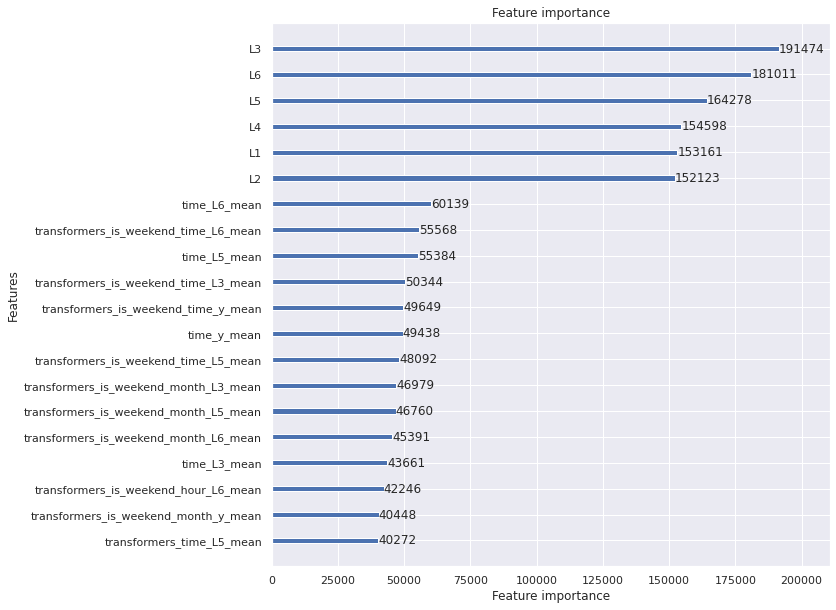

In [93]:
from optuna.integration import lightgbm as lgbp
lgbp.plot_importance(model_356, max_num_features=20, figsize=(10,10))
plt.show()

In [67]:
def cv_model_xgb(clf, train_x, train_y, test_x, seed=2023):

    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    pred = np.zeros(test_x.shape[0])

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} {}************************************'.format(str(i+1), str(seed)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        #train_matrix = clf.Dataset(trn_x, label=trn_y)
        #valid_matrix = clf.Dataset(val_x, label=val_y)

        model = clf.XGBRegressor(
        #objective='reg:pseudohubererror',
        objective='reg:squarederror',
        tree_method="hist",
        n_estimators=794,
        learning_rate=0.01,
        max_leaves = 34,
        subsample=0.70,
        colsample_bytree=0.80,
        max_bin=4096,
        n_jobs=2,
        eval_metric='mae'
    )
        model.fit(trn_x,trn_y,eval_set=[(val_x,val_y)],verbose=500,early_stopping_rounds=1000)

        test_pred = model.predict(test_x)

        pred += test_pred / kf.n_splits

    return pred


In [68]:
xgb2_pred = cv_model_xgb(xgb, train_df[cols].astype(float), train_df['y'], test_df[cols].astype(float))

************************************ 1 2023************************************

[0]	validation_0-mae:19.16624

[500]	validation_0-mae:3.00607

[793]	validation_0-mae:2.85993

************************************ 2 2023************************************

[0]	validation_0-mae:19.23803

[500]	validation_0-mae:3.02575

[793]	validation_0-mae:2.87267

************************************ 3 2023************************************

[0]	validation_0-mae:18.99500

[500]	validation_0-mae:2.93867

[793]	validation_0-mae:2.79460

************************************ 4 2023************************************

[0]	validation_0-mae:19.16547

[500]	validation_0-mae:3.06180

[793]	validation_0-mae:2.90673

************************************ 5 2023************************************

[0]	validation_0-mae:19.16287

[500]	validation_0-mae:3.00287

[793]	validation_0-mae:2.86179


In [37]:
xgb_pred

array([11.02171683, 11.32929611, 10.02444696, ..., 20.07470345,
       18.11297154, 18.27725458])

In [38]:
lgb_pred

array([ 9.67418924, 13.79349218, 10.81011688, ..., 22.30349347,
       20.06205575, 16.60616122])

In [49]:
train_df[cols]

,transformers,month,is_weekend,time,L1,L2,L3,L4,L5,L6,...,hour_L1_mean,time_span_L1_mean,transformers_month_L1_mean,transformers_time_L1_mean,transformers_hour_L1_mean,transformers_time_span_L1_mean,transformers_is_weekend_month_L1_mean,transformers_is_weekend_time_L1_mean,transformers_is_weekend_hour_L1_mean,transformers_is_weekend_time_span_L1_mean
0,1,4,0,0,16.4772,11.6558,4.4320,6.4635,4.3713,1.1885,...,23.190594,22.417344,5.147846,12.028731,11.981487,11.504955,5.39687,12.029595,11.969085,11.553994
1,1,4,0,1,16.2091,11.8867,4.4020,6.4640,4.6197,1.1879,...,23.313253,22.625739,5.018662,11.930317,12.107395,11.559884,5.537005,11.990083,12.147907,11.630435
2,1,4,0,2,15.9085,11.5495,4.3407,6.5308,4.0870,1.1272,...,22.714622,22.417344,5.147846,11.939182,11.780982,11.504955,5.39687,11.97623,11.829212,11.553994
3,1,4,0,3,15.7744,11.3179,4.2491,6.0959,4.1756,1.0818,...,23.005002,22.625739,5.018662,11.756876,11.799912,11.559884,5.537005,11.868639,11.893383,11.630435
4,1,4,0,4,15.6739,11.4603,4.3714,6.6315,4.2463,1.1573,...,22.229171,22.417344,5.147846,11.290373,11.313791,11.504955,5.39687,11.337238,11.377231,11.553994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,2,1,0,43,43.9366,46.8299,-2.7134,0.0004,0.0002,0.0005,...,24.739573,24.534024,42.292738,40.291291,40.665192,39.20057,42.297914,40.241985,40.731077,39.18357
38396,2,1,0,44,39.6642,42.7015,-2.6810,0.0004,-1.6484,0.0004,...,24.44941,24.534024,42.292738,39.313877,38.938258,39.20057,42.297914,39.193854,38.791706,39.18357
38397,2,1,0,45,39.0777,42.2995,-2.8787,0.0004,-0.7773,0.0001,...,24.862673,24.428468,42.11679,38.841311,39.246081,39.25772,42.045286,38.781997,39.27004,39.322831
38398,2,1,0,46,37.6118,41.4551,-2.8789,0.0004,0.0000,0.0001,...,24.173229,24.509555,42.129412,37.29602,36.783205,39.258562,42.037152,37.093707,36.554454,39.219341


In [ ]:

def train_model(X, X_test, y, params, folds, model_type='lgb', eval_type='regression'):
    #生成一个和训练集样本量一样大的空数列，用来存放交叉验证中的小模型在训练集上的预测值，以后会在stacking中用到这些数据
    oof = np.zeros(X.shape[0])
    #存放测试集的预测结果
    predictions = np.zeros(X_test.shape[0])#
    scores = []
    #enumerate(folds.split(X, y))返回第i折的测试集索引trn_idx、验证集索引val_idx
    for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())

        if model_type == 'lgb':
            #lightgbm要封装数据
            trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
            val_data = lgb.Dataset(X[val_idx], y[val_idx])
            #实例化一个lightgbm模型clf，在第i折的训练集上训练模型
            clf = lgb.train(params, trn_data, num_boost_round=20000,
                            valid_sets=[trn_data, val_data],
                            verbose_eval=100, early_stopping_rounds=300)
            #实例化后的模型clf在第i折的验证集上预测，并按照索引放在空数列里面，以后的stacking过程中会用到。
            oof[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)
            #在测试集上预测，将预测值除以折数，因为最终的模型预测值输出的是几个小模型预测值的平均值。
            predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

        if model_type == 'xgb':
            trn_data = xgb.DMatrix(X[trn_idx], y[trn_idx])
            val_data = xgb.DMatrix(X[val_idx], y[val_idx])
            watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
            clf = xgb.train(dtrain=trn_data, num_boost_round=20000,
                            evals=watchlist, early_stopping_rounds=200,
                            verbose_eval=100, params=params)
            oof[val_idx] = clf.predict(xgb.DMatrix(X[val_idx]), ntree_limit=clf.best_ntree_limit)
            predictions += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

        if (model_type == 'cat') and (eval_type == 'regression'):
            clf = CatBoostRegressor(iterations=20000, eval_metric='RMSE', **params)
            clf.fit(X[trn_idx], y[trn_idx],
                    eval_set=(X[val_idx], y[val_idx]),
                    cat_features=[], use_best_model=True, verbose=100)
            oof[val_idx] = clf.predict(X[val_idx])
            predictions += clf.predict(X_test) / folds.n_splits

        if (model_type == 'cat') and (eval_type == 'binary'):
            clf = CatBoostClassifier(iterations=20000, eval_metric='Logloss', **params)
            clf.fit(X[trn_idx], y[trn_idx],
                    eval_set=(X[val_idx], y[val_idx]),
                    cat_features=[], use_best_model=True, verbose=100)
            oof[val_idx] = clf.predict_proba(X[val_idx])[:,1]
            predictions += clf.predict_proba(X_test)[:,1] / folds.n_splits
        print(predictions)
        if eval_type == 'regression':
            scores.append(mean_squared_error(oof[val_idx], y[val_idx])**0.5)
        if eval_type == 'binary':
            scores.append(log_loss(y[val_idx], oof[val_idx]))

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

    return oof, predictions, scores


In [51]:
test_df['y'] = (lgb_pred_op_noL2+lgb_pred_op)/2
test_df[['id','y']].to_csv('submit_op_sum.csv', index=False)

In [52]:
lgb_pred_op

array([ 9.29516497,  9.33382014,  9.36417667, ..., 10.33396414,
       10.53839209, 10.6003896 ])